# FastSAM
<a target="blank" href="https://colab.research.google.com/github/mora-bprs/SAM-model/blob/thuva/fastSAM.ipynb">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Initialize

In [20]:
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import gdown
import shutil

###############
COLAB = False # edit this to True in Google Colab
###############

print(f"PyTorch v{torch.__version__}")
print(f"Torchvision v{torchvision.__version__}")
CUDA = torch.cuda.is_available()
MPS = torch.backends.mps.is_available()
print(f"CUDA Available: {CUDA}")
print(f"MPS Available: {MPS}")
device = "cuda" if CUDA else "cpu"
ROOT = os.getcwd() if not COLAB else "/content"
print("CWD:", ROOT)

PyTorch v2.3.0
Torchvision v0.18.0
CUDA Available: False
MPS Available: True
CWD: /Users/tony/dev/SAM-model


## Test dataset setup

In [21]:
RESET_DATASET = False
if not os.path.exists("train") or RESET_DATASET:
    shutil.rmtree("train", ignore_errors=True)
    gdown.download("https://drive.google.com/uc?id=1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc", "box_train.zip", quiet=False)
    !unzip box_train.zip
    os.remove("box_train.zip")
else:
    print("Dataset already downloaded")

DATASET_PATH = f"{ROOT}/train"

Dataset already downloaded


## FastSAM package & Pretrained weights setup

In [22]:
# download FastSAM and weights
RESET_FASTSAM = False
if RESET_FASTSAM or not os.path.exists("FastSAM"):
    if os.path.exists("FastSAM"):
        shutil.rmtree("FastSAM", ignore_errors=False)
    !git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
    !wget https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt


In [23]:
if COLAB:
    %pip install segment-anything-fast
else:
    %pip install -r requirements.txt # disable this if not initial setup
%pip install -r FastSAM/requirements.txt
%pip install git+https://github.com/openai/CLIP.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/openai/CLIP.git to /private/var/folders/2j/pvqqyvg55vdb3xz5tmq6gc2h0000gn/T/pip-req-build-wwmv0f4l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/2j/pvqqyvg55vdb3xz5tmq6gc2h0000gn/T/pip-req-build-wwmv0f4l
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [24]:
### downloading FastSAM weights (pretrained model checkpoints)
# two model versions of the model are available with different sizes.
# `FastSAM` will be referred as `FastSAM-x` (https://drive.google.com/file/d/1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv/view)
# `FastSAM-s` (https://drive.google.com/file/d/10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV/view)

RESET_FASTSAM = False
if RESET_FASTSAM:
    if os.path.exists("FastSAM-s.pt"):
        os.remove("FastSAM-s.pt")
    if os.path.exists("FastSAM-x.pt"):
        os.remove("FastSAM-x.pt")
if not os.path.exists("FastSAM-s.pt"):
    gdown.download("https://drive.google.com/uc?id=10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV", "FastSAM-s.pt", quiet=False)
if not os.path.exists("FastSAM-x.pt"):
    gdown.download("https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv", "FastSAM-x.pt", quiet=False)

In [25]:
from fastsam import FastSAM, FastSAMPrompt

fast_sam_x_checkpoint = f"{ROOT}/FastSAM-x.pt"
fast_sam_s_checkpoint = f"{ROOT}/FastSAM-s.pt"
# model_type = "vit_h"
model_fast_sam_x = FastSAM(fast_sam_x_checkpoint)
model_fast_sam_s = FastSAM(fast_sam_s_checkpoint)

___

## Testing box detection on FastSAM models

In [26]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


Image resolution: 301x167
Image resolution: 275x183
Image resolution: 289x175
Image resolution: 1087x793


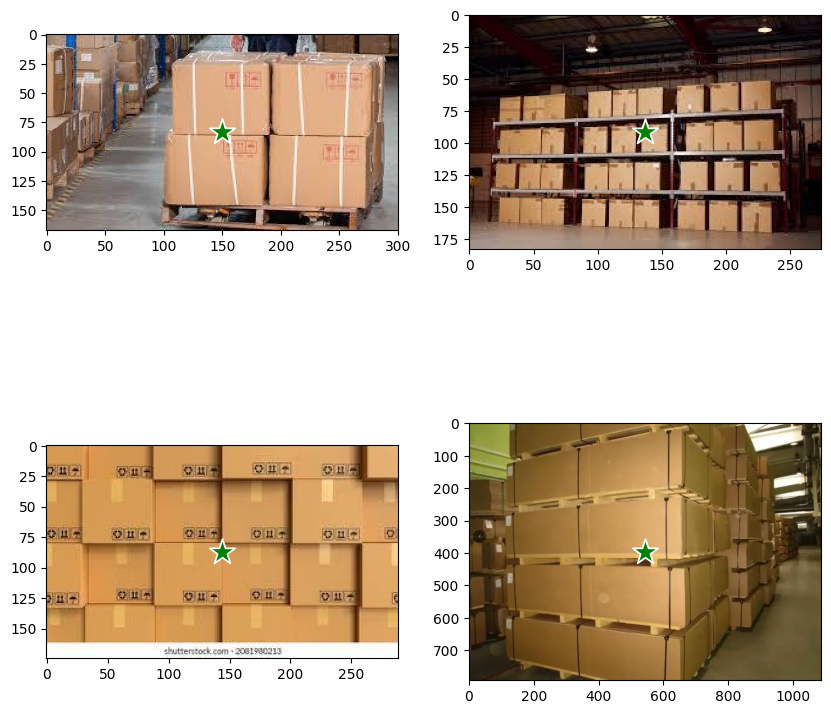

In [27]:
def list_image_files(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more if needed
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(root, file))
    return image_files

def plot_image(image):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  plt.axis('on')
  plt.show()

def plot_images(image1, image2, image3, image4):
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  ax[0, 0].imshow(image1)
  ax[0, 0].axis('on')
  ax[0, 1].imshow(image2)
  ax[0, 1].axis('on')
  ax[1, 0].imshow(image3)
  ax[1, 0].axis('on')
  ax[1, 1].imshow(image4)
  ax[1, 1].axis('on')
  plt.show()

def get_center_coords(image):
  image_height, image_width, _ = image.shape
  print(f"Image resolution: {image_width}x{image_height}")
  center_point_coords = [ int(image_width/2), int(image_height/2)]
  # return np.array([center_point_coords]), np.array([1])
  return np.array([center_point_coords])

def plot_images_with_center_coords(image1, image2, image3, image4):
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  ax[0, 0].imshow(image1)
  ax[0, 0].axis('on')
  show_points(*get_center_coords(image1), 1, ax[0, 0])
  ax[0, 1].imshow(image2)
  ax[0, 1].axis('on')
  show_points(*get_center_coords(image2), 1, ax[0, 1])
  ax[1, 0].imshow(image3)
  ax[1, 0].axis('on')
  show_points(*get_center_coords(image3), 1, ax[1, 0])
  ax[1, 1].imshow(image4)
  ax[1, 1].axis('on')
  show_points(*get_center_coords(image4), 1, ax[1, 1])
  plt.show()


image_paths = list_image_files(DATASET_PATH)
sample_img_path = image_paths[40]
image = cv2.imread(sample_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image1 = cv2.imread(image_paths[10])
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread(image_paths[20])
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.imread(image_paths[30])
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.imread(image_paths[40])
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

# plot_image(image)
# plot_images(image1, image2, image3, image4)

plot_images_with_center_coords(image1, image2, image3, image4)

### Mask prediction

In [28]:
def fastsam_maskgen(model, image, device=device, retina_masks=True, imgsz=960, conf=0.4, iou=0.9):
    """
    utility function to easily generate masks from FastSAM models
    """
    if model == 0:
        return FastSAMPrompt(image, model_fast_sam_x(image, device=device, retina_masks=retina_masks, imgsz=imgsz, conf=conf, iou=iou), device=device).point_prompt(points=get_center_coords(image), pointlabel=[1])
    elif model == 1:
        return FastSAMPrompt(image, model_fast_sam_s(image, device=device, retina_masks=retina_masks, imgsz=imgsz, conf=conf, iou=iou), device=device).point_prompt(points=get_center_coords(image), pointlabel=[1])
    else:
        return "Invalid model"

# fast_sam_x_predictor = model_fast_sam_x(image, device=device, retina_masks=True, imgsz=960, conf=0.4, iou=0.9,)
# fast_sam_x_prompt_process = FastSAMPrompt(image, fast_sam_x_predictor, device=device)
# fast_sam_s_predictor = model_fast_sam_s(image, device=device, retina_masks=True, imgsz=960, conf=0.4, iou=0.9,)
# fast_sam_s_prompt_process = FastSAMPrompt(image, fast_sam_s_predictor, device=device)

In [29]:
x_mask = fastsam_maskgen(0, image)
s_mask = fastsam_maskgen(1, image)

# ANNOTATED_PATH = f"{ROOT}/annotate/box.jpg"
# BUG: tkinter kernel crash, unexpected behavior
# fast_sam_prompt_process.plot(annotations=mask,output_path=ANNOTATED_PATH)


0: 704x960 41 objects, 1014.8ms
Speed: 2.6ms preprocess, 1014.8ms inference, 103.9ms postprocess per image at shape (1, 3, 960, 960)



Image resolution: 1087x793


0: 704x960 37 objects, 226.3ms
Speed: 2.2ms preprocess, 226.3ms inference, 82.5ms postprocess per image at shape (1, 3, 960, 960)


Image resolution: 1087x793


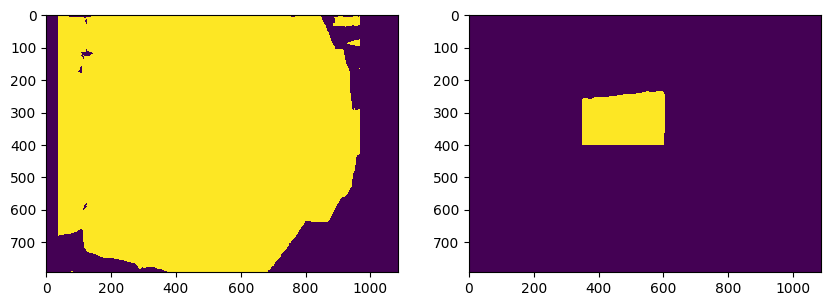

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(x_mask[0], interpolation='none')
ax[1].imshow(s_mask[0], interpolation='none')
# show_mask(x_mask, ax[0])
# show_mask(s_mask, ax[1])
plt.show()

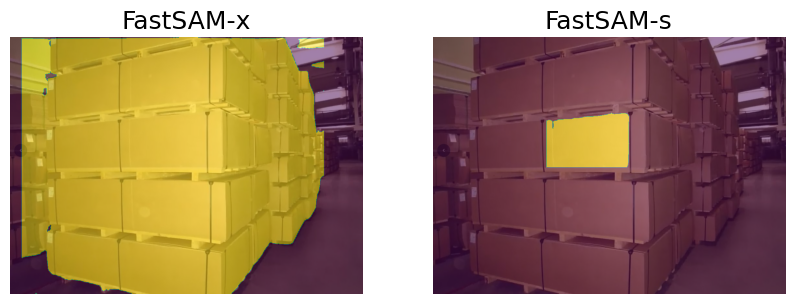

In [31]:
def plot_masks(image, mask1, mask2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].imshow(mask1, alpha=0.5)
    ax[0].set_title("FastSAM-x", fontsize=18)
    ax[0].axis('off')

    ax[1].imshow(image)
    ax[1].imshow(mask2, alpha=0.5)
    ax[1].set_title("FastSAM-s", fontsize=18)
    ax[1].axis('off')

    plt.show()


# plot_mask_with_score(image, "FastSAM-x output", x_mask, get_center_coords(image), np.array([1]) )
# plot_mask_with_score(image, "FastSAM-s output", s_mask, get_center_coords(image), np.array([1]) )

# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(image)
# show_mask(x_mask, ax[0].gca())
# show_points(*get_center_coords(image), np.array([1]), plt.gca())
# ax[0].set_title("FastSAM-x", fontsize=18)
# ax[0].axis('on')
# ax[1].imshow(image)
# show_mask(s_mask, ax[1].gca())
# show_points(*get_center_coords(image), np.array([1]),plt.gca())
# ax[1].set_title("FastSAM-s", fontsize=18)
# ax[1].axis('on')
# plt.show()

plot_masks(image, x_mask[0], s_mask[0])


0: 544x960 30 objects, 254.3ms
Speed: 4.0ms preprocess, 254.3ms inference, 3.5ms postprocess per image at shape (1, 3, 960, 960)



Image resolution: 301x167


0: 640x960 51 objects, 212.0ms
Speed: 1.6ms preprocess, 212.0ms inference, 6.6ms postprocess per image at shape (1, 3, 960, 960)



Image resolution: 275x183


0: 608x960 75 objects, 185.3ms
Speed: 1.5ms preprocess, 185.3ms inference, 8.2ms postprocess per image at shape (1, 3, 960, 960)



Image resolution: 289x175


0: 704x960 37 objects, 279.8ms
Speed: 2.6ms preprocess, 279.8ms inference, 96.2ms postprocess per image at shape (1, 3, 960, 960)


Image resolution: 1087x793


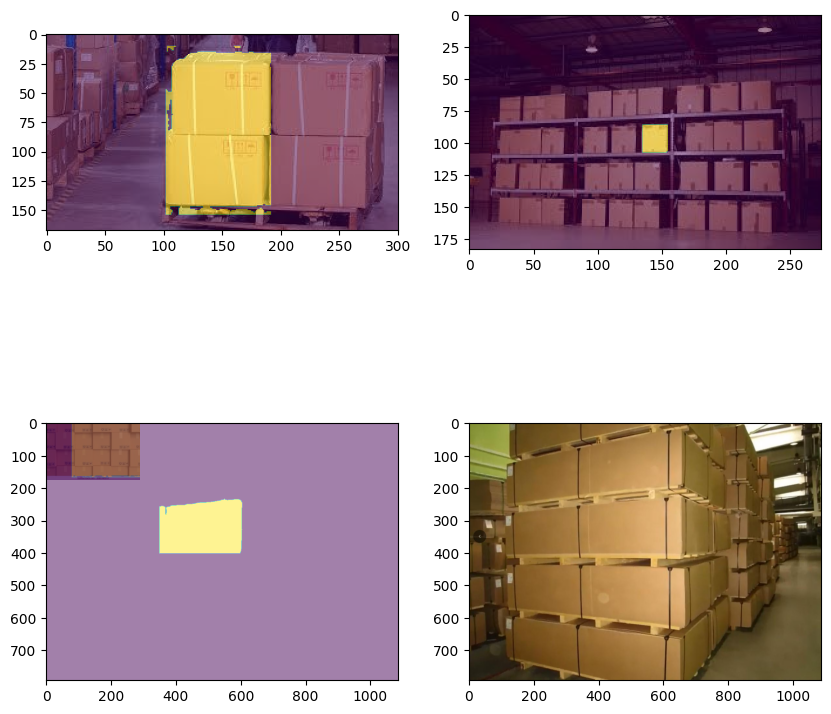

In [42]:
def plot_images_with_mask(model, image1, image2, image3, image4):
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  ax[0, 0].imshow(image1)
  ax[0,0].imshow(fastsam_maskgen(model, image1)[0], alpha=0.5)
  ax[0, 1].imshow(image2)
  ax[0,1].imshow(fastsam_maskgen(model, image2)[0], alpha=0.5)
  ax[1, 0].imshow(image3)
  ax[1,0].imshow(fastsam_maskgen(model, image3)[0], alpha=0.5)
  ax[1, 1].imshow(image4)
  ax[1,0].imshow(fastsam_maskgen(model, image4)[0], alpha=0.5)
  plt.show()

plot_images_with_mask(1, image1, image2, image3, image4)

# WIP
---

In [32]:
sample_mask = x_mask
sample_mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [33]:
sample_mask.shape

(1, 793, 1087)

In [34]:
image.shape

(793, 1087, 3)

The mask and the image are not in the correct matching dimensions. We have to map this one.


In [35]:
reshaped_mask = np.transpose(sample_mask, (1, 2, 0))
reshaped_mask.shape

(793, 1087, 1)

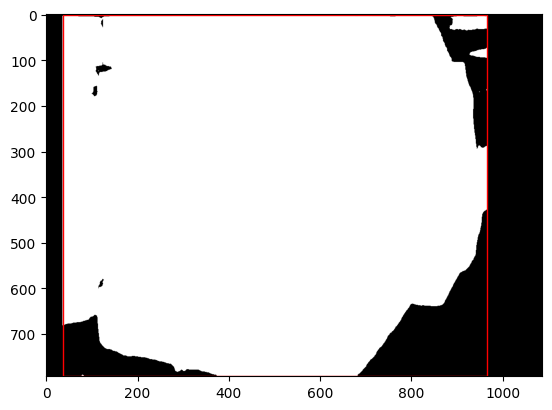

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_square(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = np.min(true_indices, axis=0)
    bottom_right = np.max(true_indices, axis=0)

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the mask
    ax.imshow(mask, cmap='gray')

    # Create a rectangle patch
    rect = patches.Rectangle((top_left[1], top_left[0]), width, height, linewidth=1, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the axis
    ax.add_patch(rect)

    # Show the plot
    plt.show()

# Example usage:
# Assuming you have your mask array named "mask"
plot_square(reshaped_mask)


In [37]:
import numpy as np

def get_bounding_box_coordinates(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = np.min(true_indices, axis=0)
    bottom_right = np.max(true_indices, axis=0)

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # Calculate the coordinates of the corners
    top_right = (top_left[1] + width, top_left[0])
    bottom_left = (top_left[1], top_left[0] + height)
    bottom_right = (top_left[1] + width, top_left[0] + height)

    return top_left, top_right, bottom_left, bottom_right

# Example usage:
# Assuming you have your mask array named "mask"
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates(reshaped_mask)
print("Top left:", top_left)
print("Top right:", top_right)
print("Bottom left:", bottom_left)
print("Bottom right:", bottom_right)


Top left: [ 0 36  0]
Top right: (966, 0)
Bottom left: (36, 792)
Bottom right: (966, 792)


In [38]:
import numpy as np

def get_bounding_box_coordinates_updated(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = np.min(true_indices, axis=0)
    bottom_right = np.max(true_indices, axis=0)

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # Calculate the coordinates of the corners
    top_right = (top_left[1] + width, top_left[0])
    bottom_left = (top_left[1], top_left[0] + height)
    bottom_right = (top_left[1] + width, top_left[0] + height)

    top_left[0] = top_right[0] - (bottom_right[0]-bottom_left[0])
    top_left[1] = (top_right[1]-bottom_right[1]) + bottom_left[1]

    return top_left, top_right, bottom_left, bottom_right

# Example usage:
# Assuming you have your mask array named "mask"
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates_updated(sample_mask)
print("Top left:", top_left)
print("Top right:", top_right)
print("Bottom left:", bottom_left)
print("Bottom right:", bottom_right)


Top left: [ 0  0 36]
Top right: (792, 0)
Bottom left: (0, 0)
Bottom right: (792, 0)


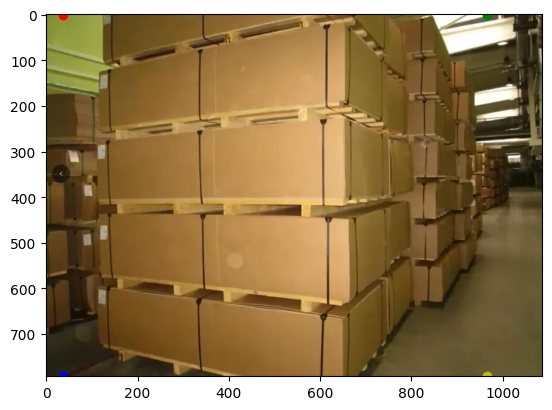

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_image_annotated.jpg'

<Figure size 640x480 with 0 Axes>

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, save_path):
    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the original image
    ax.imshow(image)

    # Annotate the corners
    ax.plot(top_left[0], top_left[1], 'ro')          # Top Left corner
    ax.plot(top_right[0], top_right[1], 'go')        # Top Right corner
    ax.plot(bottom_left[0], bottom_left[1], 'bo')    # Bottom Left corner
    ax.plot(bottom_right[0], bottom_right[1], 'yo')  # Bottom Right corner

    # Show the plot
    plt.show()

    # Save the plot to the specified path
    plt.savefig(save_path)

    # Close the plot to release resources
    # plt.close()

# Example usage:
# Assuming you have your original image as "image" and the corners' coordinates obtained from get_square_corners
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates_updated(reshaped_mask)
annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, "/content/sample_image_annotated.jpg")


In [ ]:
import matplotlib.pyplot as plt

def annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, save_path):
    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the original image
    ax.imshow(image)

    # Annotate the corners
    ax.plot(top_left[0], top_left[1], 'ro')          # Top Left corner
    ax.plot(top_right[0], top_right[1], 'go')        # Top Right corner
    ax.plot(bottom_left[0], bottom_left[1], 'bo')    # Bottom Left corner
    ax.plot(bottom_right[0], bottom_right[1], 'yo')  # Bottom Right corner

    # Save the plot to the specified path
    plt.savefig(save_path)

    plt.show()

    # Close the plot to release resources
    # plt.close()


# Example usage:
# Assuming you have your image and corner coordinates
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates_updated(reshaped_mask)
annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, "/content/sample_image_annotated.jpg")


## Pipeline

In [ ]:
def get_box_coordinates_fast_sam(image_path:str,model_path:str, isFastSAM=True, showOriginalImage=False, showPoints=True, showPlotMaskWithHighestScore=True):
  # load image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # plot original image
  if showOriginalImage:
    plot_image(img)

  # get image dimensions
  img_height, img_width, _ = img.shape

  # get centre point coordinates
  center_point_coords = [ int(img_width/2), int(img_height/2)]
  input_point = np.array([center_point_coords])
  input_label = np.array([1])

  if showPoints:
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()


  # draw a rectangle that makes the center point of image

  # generate the mask in the relevant area
  if isFastSAM:
    model_fast_sam = FastSAM(model_path)
    fast_sam_predictor = model_fast_sam(img, device=device, retina_masks=True, imgsz=img_width, conf=0.4, iou=0.9,)
    fast_sam_prompt_process = FastSAMPrompt(img, fast_sam_predictor, device=device)

    # point prompt
    # points default [[0,0]] [[x1,y1],[x2,y2]]
    # point_label default [0] [1,0] 0:background, 1:foreground
    img_mask = fast_sam_prompt_process.point_prompt(points=input_point, pointlabel=input_label)


    # plot_mask_with_score(img, "FastSAM output", img_mask, input_point, input_label )

    # reshape image mask
    # print(img_mask.shape)
    img_mask = np.transpose(img_mask, (1, 2, 0))
    # print(img_mask.shape)

  if showPlotMaskWithHighestScore:
    plot_square(img_mask)

  # get the rectangular boxes
  img_top_left, img_top_right, img_bottom_left, img_bottom_right = get_bounding_box_coordinates_updated(img_mask)

  # get the coordinates of the rectangular bounding box
  annotate_square_corners(img, img_top_left, img_top_right, img_bottom_left, img_bottom_right, "/content/annotated_box_image.jpg")



In [ ]:
time_list = []

# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(image_paths[5], model_path=fast_sam_x_checkpoint, isFastSAM=True, showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=True)

time_list.append(time.time()-start_time)
print(f"Time taken for operation : {time_list[-1]}")

### Time ; if no images are not shown to the output

In [ ]:
# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(image_paths[5], model_path=fast_sam_x_checkpoint, isFastSAM=True, showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=False)

time_list.append(time.time()-start_time)
print(f"Time taken for operation : {time_list[-1]}")

## Using FAST SAM S model

In [ ]:
# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(image_paths[5], model_path=fast_sam_s_checkpoint, isFastSAM=True, showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=False)

time_list.append(time.time()-start_time)
print(f"Time taken for operation : {time_list[-1]}")

In [ ]:
################## Have to change this below this line ...

In [ ]:
time_list = []

In [ ]:
output_images_path = "/content/drive/MyDrive/annotated_boxes_fast_sam/"

In [ ]:
try:
  os.makedirs(output_images_path)
except FileExistsError:
  print("folder already exists")

In [ ]:
def get_box_coordinates_updated(image_path:str,showOriginalImage=False, showPoints=True, showMasksWithScores=True, showPlotMaskWithHighestScore=True):
  img_name = image_path.split("/")[-1]
  # load image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # plot original image
  if showOriginalImage:
    plot_image(img)

  # get image dimensions
  img_height, img_width, _ = img.shape

  # get centre point coordinates
  center_point_coords = [ int(img_width/2), int(img_height/2)]
  input_point = np.array([center_point_coords])
  input_label = np.array([1])

  if showPoints:
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()


  # draw a rectangle that makes the center point of image

  # generate masks in the relevant area
  predictor.set_image(img)

  img_masks, img_masks_scores, img_masks_logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
  )

  if showMasksWithScores:
    for i, (mask, score) in enumerate(zip(img_masks, img_masks_scores)):
        plot_mask_with_score(img, i+1, mask, score, input_point, input_label)


  # get the mask with the highest score
  img_mask_with_highest_score, img_mask_highest_score, img_mask_logits_for_highest_score = get_mask_with_highest_score(img_masks, img_masks_scores, img_masks_logits)

  if showPlotMaskWithHighestScore:
    plot_square(img_mask_with_highest_score)

  # get the rectangular boxes
  img_top_left, img_top_right, img_bottom_left, img_bottom_right = get_bounding_box_coordinates_updated(img_mask_with_highest_score)

  # get the coordinates of the rectangular bounding box

  annotate_square_corners(img, img_top_left, img_top_right, img_bottom_left, img_bottom_right, output_images_path+img_name)

In [ ]:
get_box_coordinates_updated(image_paths[0],showOriginalImage=False, showPoints=False, showMasksWithScores=False, showPlotMaskWithHighestScore=False)


In [ ]:
updated_time_list = []

In [ ]:
for img_path in image_paths:
  # start_time = time.time()
  get_box_coordinates_updated(img_path,showOriginalImage=False, showPoints=False, showMasksWithScores=False, showPlotMaskWithHighestScore=False)

  # updated_time_list.append(time.time()-start_time)
  # print(f"Time taken for operation : {time_list[-1]}")


In [ ]:
updated_avg_time = sum(updated_time_list)/len(image_paths)
print("Average time for inference :", updated_avg_time, " s")